In [ ]:
noise_level=0.2

In [ ]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *
import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def doppler(x):
    """
    Parameters
    ----------
    x : array-like
        Domain of x is in (0,1]
 
    """
    if not np.all((x >= 0) & (x <= 1)):
        raise ValueError("Domain of doppler is x in (0,1]")
    return np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+.05))
 
def blocks(x):
    """
    Piecewise constant function with jumps at t.
 
    Constant scaler is not present in Donoho and Johnstone.
    """
    K = lambda x : (1 + np.sign(x))/2.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]]).T
    return 3.655606 * np.sum(h*K(x-t), axis=0)
 
def bumps(x):
    """
    A sum of bumps with locations t at the same places as jumps in blocks.
    The heights h and widths s vary and the individual bumps are of the
    form K(t) = 1/(1+|x|)**4
    """
    K = lambda x : (1. + np.abs(x)) ** -4.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 2.1, 4.2]]).T
    w = np.array([[.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]]).T
    return np.sum(h*K((x-t)/w), axis=0)
 
def heavisine(x):
    """
    Sinusoid of period 1 with two jumps at t = .3 and .72
    """
    return 4 * np.sin(4*np.pi*x) - np.sign(x - .3) - np.sign(.72 - x)
     

x = np.linspace(0,1,2**8)
dop = doppler(x)
blk = blocks(x)
bmp = bumps(x)
hsin = heavisine(x)
 
 
# Generate a sample signal 
signal = doppler (x) + np.random.normal(0,noise_level ,x.shape)
 
# Perform wavelet decomposition
wavelet = 'db1'
coeffs_noisy = pywt.wavedec(signal, wavelet )
def build_dyadic_wavelet_graph(coeffs, noise_level):
    """
    Build a dyadic graph from wavelet decomposition coefficients with noise levels.
    Each node at level n is connected to two nodes at level n+1.
    
    Parameters
    ----------
    coeffs : list of arrays
        Wavelet decomposition coefficients.
    noise_level : float
        Noise level to associate with each node.

    Returns
    -------
    Data : torch_geometric.data.Data
        PyTorch Geometric graph data object.
    node_labels : dict
        Dictionary mapping node indices to labels.
    node_levels : dict
        Dictionary mapping node indices to levels.
    node_coefficients : dict
        Dictionary mapping node indices to wavelet coefficients.
    """
    node_features = []  # To store node features as (coefficient, noise_level)
    edges = []  # To store edges
    node_labels = {}  # To label nodes for visualization
    node_levels = {}  # To store levels for layout
    node_coefficients = {}  # To store wavelet coefficients for color mapping

    current_node = 0  # Node counter

    # Add root node (original signal approximation)
    root_coeff = coeffs[0][0]
    root_feature = (root_coeff, noise_level)  # Tuple with coefficient and noise level
    node_features.append(root_feature)
    node_labels[current_node] = "Root (s,0)"
    node_levels[current_node] = 0
    node_coefficients[current_node] = root_coeff

    parent_nodes = [current_node]  # Track parent nodes for dyadic connections
    current_node += 1

    # Process detail coefficients for wavelet levels
    for level, c in enumerate(coeffs[1:], start=1):
        new_parent_nodes = []  # Track new parent nodes for the next level
        for parent in parent_nodes:
            # Each parent connects to two children
            for i in range(2):
                if len(c) > 2 * (parent - parent_nodes[0]) + i:  # Check if index is within bounds
                    coeff_index = 2 * (parent - parent_nodes[0]) + i
                    noisy_coeff = c[coeff_index]  # Coefficient value
                    node_feature = (noisy_coeff, noise_level)  # Tuple with coefficient and noise
                    node_features.append(node_feature)
                    s_or_l = "s" if i == 0 else "l"  # Determine short (s) or long (l) connection
                    node_labels[current_node] = f"Level {level} ({s_or_l},{coeff_index})"
                    node_levels[current_node] = level
                    node_coefficients[current_node] = noisy_coeff  # Store wavelet coefficient
                    edges.append([parent, current_node])  # Add edge
                    new_parent_nodes.append(current_node)
                    current_node += 1
        parent_nodes = new_parent_nodes  # Update parent nodes for next level

    # Convert node features to PyTorch tensors
    features_tensor = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=features_tensor, edge_index=edge_index), node_labels, node_levels, node_coefficients
# Draw the graph with improved visualization
def draw_dyadic_wavelet_graph_pyramid(g, node_labels, node_levels, node_coefficients):
    plt.figure(figsize=(12, 8))
    for node, level in node_levels.items():
        g.nodes[node]['subset'] = level  # Add subset information for each node
    pos = nx.multipartite_layout(g, subset_key='subset')  # Arrange in levels

    # Normalize coefficients for color mapping
    coeff_values = list(node_coefficients.values())
    norm = mcolors.Normalize(vmin=min(coeff_values), vmax=max(coeff_values))
    cmap = plt.cm.RdBu_r  # Red for positive, blue for negative

    node_colors = [cmap(norm(node_coefficients[node])) for node in g.nodes()]

    nx.draw(
        g, pos, with_labels=True, labels=node_labels,
        node_size=(70), node_color=node_colors, font_size=2, font_weight="bold", edge_color="gray"
    )
    plt.gca().invert_yaxis()  # Invert Y-axis for top-down pyramid
    plt.title("Dyadic Wavelet Graph Pyramid Visualization with Coefficients", fontsize=14)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(coeff_values) 
    plt.show()

def draw_predictions(g, predictions):
    plt.figure(figsize=(12, 8))
    pos = nx.multipartite_layout(g, subset_key='subset')

    # Ensure alignment between graph nodes and predictions
    node_colors = []
    for node in g.nodes():
        try:
            node_colors.append(predictions[node].item())  # Use predictions[node] if aligned
        except IndexError:
            raise ValueError(f"Prediction for node {node} is out of bounds.")

    cmap = plt.cm.RdBu_r
    norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))

    nx.draw(
        g, pos, with_labels=True,
        node_size=700, node_color=node_colors, cmap=cmap, font_size=8, font_weight="bold", edge_color="gray"
    )
    plt.gca().invert_yaxis()
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), label="Predicted Coefficients")
    plt.title("Wavelet Graph with Predictions")
    plt.show()


 
# Build the dyadic wavelet graph
wavelet_graph_noisy, node_labels_noisy, node_levels_noisy, node_coefficients_noisy = build_dyadic_wavelet_graph(coeffs_noisy, noise_level)

# Convert to NetworkX for visualization
g = torch_geometric.utils.to_networkx(wavelet_graph_noisy, to_undirected=True)





num_classes = 20
betahat=np.concatenate( coeffs_noisy)
sebetahat= np.full_like(np.concatenate( coeffs_noisy) ,0.2 )
betatrue= np.concatenate(pywt.wavedec(doppler(x),wavelet))
scale = autoselect_scales_mix_norm(betahat ,
                                   sebetahat , 
                                       max_class=num_classes ) 

num_classes= scale.shape[0]
print( (scale) )
print(scale.shape)


fit_como_data_loglik = get_data_loglik_normal(betahat=np.concatenate( coeffs_noisy),
                                                sebetahat= np.full_like(np.concatenate( coeffs_noisy) ,0.2 ),
                                                location=0*scale,
                                              scale=scale)

 
# Convert data to PyTorch tensors 
y_train = torch.FloatTensor(fit_como_data_loglik)


[0.         0.24011084 0.48022167 0.72033251 0.96044334 1.20055418
 1.44066501 1.68077585 1.92088668 2.16099752 2.40110835 2.64121919
 2.88133002 3.12144086 3.3615517  3.60166253 3.84177337 4.0818842
 4.32199504 4.56210587]
(20,)


In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Define the GNN model
class SimpleGNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Graph convolution layers with ReLU activation
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.relu(self.conv3(x, edge_index))

        # Fully connected layer and softmax
        x = self.fc(x)
        x = self.softmax(x)
        return x


# Custom loss function
def custom_loss(pred_pi, marginal_log_lik, penalty=10.1, epsilon=1e-10):
    """
    Compute the penalized log likelihood function using vectorized operations.

    Parameters:
    pred_pi (torch.Tensor): A tensor of shape (batch_size, K) corresponding to pi_k for each sample.
    marginal_log_lik (torch.Tensor): A tensor of shape (batch_size, K) corresponding to the log-likelihoods.
    penalty (float): The penalty term.
    epsilon (float): Small constant to avoid log of zero or division by zero.

    Returns:
    torch.Tensor: The negative penalized log likelihood (for minimization purposes).
    """
    # Compute L_batch as the exponentiated marginal_log_lik (this is vectorized across all rows)
    L_batch = torch.exp(marginal_log_lik)

    # Element-wise multiplication between pred_pi and L_batch, sum over the components (columns)
    inner_sum = torch.sum(pred_pi * L_batch, dim=1)
    # Ensure inner_sum is not too small to avoid log(0) or log(negative)
    inner_sum = torch.clamp(inner_sum, min=epsilon)

    # Compute the first sum: sum of log(inner_sum) across the minibatch (batch_size)
    first_sum = torch.sum(torch.log(inner_sum))

    # Penalty term: based on the first component of pred_pi (penalty on pred_pi[:, 0])
    if penalty > 1:
        pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
        penalized_log_likelihood_value = first_sum + (penalty - 1) * torch.log(pi_clamped)
    else:
        penalized_log_likelihood_value = first_sum

    # Return the negative of the penalized log-likelihood
    return -penalized_log_likelihood_value


# Model parameters
input_size = 2  # Each node feature contains (coefficient, noise level)
hidden_size = 64
num_classes = num_classes  # Determined by scale in your dataset

# Instantiate the model
model = SimpleGNN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 2000  # Number of training epochs
model.train()

 # Define the function to store predictions in an array
def get_predictions_array(predictions, num_nodes, num_classes):
    """
    Converts the GNN output predictions to a numpy array of size (n_coeffs, num_classes).

    Parameters
    ----------
    predictions : torch.Tensor
        The GNN output predictions of shape (num_nodes, num_classes).
    num_nodes : int
        The number of nodes in the graph.
    num_classes : int
        The number of output classes (mixture proportions).

    Returns
    -------
    np.ndarray
        Array of size (num_nodes, num_classes) containing the predicted mixture proportions.
    """
    return predictions.detach().cpu().numpy().reshape(num_nodes, num_classes)


# Training loop
num_epochs = 3000  # Number of training epochs
model.train()

for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero out the gradients

    # Forward pass
    predictions = model(wavelet_graph_noisy)

    # Compute the custom loss
    loss = custom_loss(predictions, y_train)

    # Backpropagation
    loss.backward()

    # Update parameters
    optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Store predictions in a numpy array
model.eval()
with torch.no_grad():
    predictions = model(wavelet_graph_noisy)

# Convert predictions to numpy array
num_nodes = wavelet_graph_noisy.num_nodes
predictions_array = get_predictions_array(predictions, num_nodes, num_classes)

print(f"Predictions array shape: {predictions_array.shape}")
print(predictions_array)

Epoch 1/3000, Loss: 257.43902587890625
Epoch 2/3000, Loss: 246.729736328125
Epoch 3/3000, Loss: 232.48699951171875
Epoch 4/3000, Loss: 208.46080017089844
Epoch 5/3000, Loss: 170.4045867919922
Epoch 6/3000, Loss: 115.57640075683594
Epoch 7/3000, Loss: 48.68088912963867
Epoch 8/3000, Loss: -14.707918167114258
Epoch 9/3000, Loss: -58.623165130615234
Epoch 10/3000, Loss: -77.34390258789062
Epoch 11/3000, Loss: -75.7486572265625
Epoch 12/3000, Loss: -66.33584594726562
Epoch 13/3000, Loss: -57.820343017578125
Epoch 14/3000, Loss: -52.951576232910156
Epoch 15/3000, Loss: -52.10948181152344
Epoch 16/3000, Loss: -55.034305572509766
Epoch 17/3000, Loss: -61.407676696777344
Epoch 18/3000, Loss: -70.93354797363281
Epoch 19/3000, Loss: -82.30555725097656
Epoch 20/3000, Loss: -89.26698303222656
Epoch 21/3000, Loss: -72.75056457519531
Epoch 22/3000, Loss: -80.48568725585938
Epoch 23/3000, Loss: -91.5589599609375
Epoch 24/3000, Loss: -94.2459945678711
Epoch 25/3000, Loss: -95.53273010253906
Epoch 26/3

In [3]:

n_samples=256
est_post = np.zeros(n_samples)
for i in range(n_samples):
    est_post[i] = posterior_mean_norm(
        betahat= np.array([betahat[i]]),
        sebetahat=np.array([sebetahat[i]])    ,
        log_pi=np.log(predictions_array[i, :]),
        scale= scale  # Assuming this is available from earlier in your code
    ).post_mean

C:\Users\WD\AppData\Local\Temp\ipykernel_15104\1806242229.py:7: RuntimeWarning: divide by zero encountered in log
  log_pi=np.log(predictions_array[i, :]),
C:\Users\WD\AppData\Local\Temp\ipykernel_15104\1806242229.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(


In [4]:
res_ash= ash(np.concatenate( coeffs_noisy), np.full_like(np.concatenate( coeffs_noisy) , noise_level ))

In [5]:
import copy

# Create deep copies 

ncoeffs_ash= copy.deepcopy(coeffs_noisy)
h=0
for  s in range(len(ncoeffs_ash)):
    for l in range(ncoeffs_ash[s].shape[0] ):
        ncoeffs_ash[s][l] =res_ash.post_mean[h]
        h=h+1

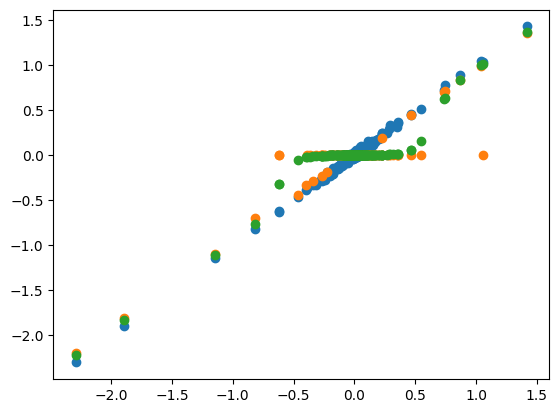

In [6]:
plt.scatter(betahat, betatrue)

plt.scatter(betahat, est_post)

plt.scatter(betahat, res_ash.post_mean)

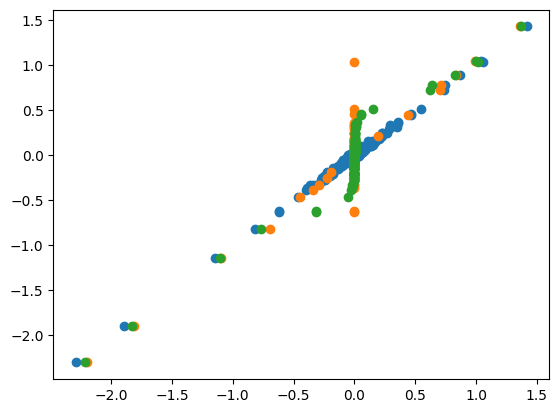

In [7]:
 
plt.scatter(betahat,betatrue)
plt.scatter(  est_post,betatrue)

plt.scatter(  res_ash.post_mean,betatrue)


In [8]:
mse_ash = np.mean((res_ash.post_mean - betatrue)**2)
mse_gnn_ash = np.mean((est_post -  betatrue)**2)
print(f"MSE (Ash Post vs True): {mse_ash:.4f}")
print(f"MSE (Gnn ash Est  vs   True): {mse_gnn_ash:.4f}")

MSE (Ash Post vs True): 0.0154
MSE (Gnn ash Est  vs   True): 0.0205


In [9]:
ncoeffs= copy.deepcopy(coeffs_noisy)
h=0
for  s in range(len(ncoeffs)):
    for l in range(ncoeffs[s].shape[0] ):
        ncoeffs[s][l] =est_post[h]
        h=h+1

In [10]:
ncoeffs

[array([0.7098018]),
 array([-7.6446455e-05]),
 array([-2.26124897e-14, -1.81198778e+00]),
 array([ 3.58691852e-13, -1.09977408e+00, -2.19463854e+00,  9.93646554e-01]),
 array([-6.45802721e-17, -1.00166031e-16,  1.35798836e+00,  8.32208557e-01,
        -2.27062519e-01, -6.96580095e-01,  9.61478551e-06,  5.05743513e-04]),
 array([ 4.40343026e-20, -1.52626057e-19,  2.39069646e-19,  5.48675457e-15,
         4.41825066e-01, -4.44241330e-01, -1.88686833e-04,  7.04605110e-01,
         1.93712614e-01, -2.87549538e-01, -3.36756455e-01, -1.89199011e-01,
         1.20852402e-20,  1.41897156e-19,  1.43029902e-18,  2.73874212e-19]),
 array([-1.61821030e-20,  3.69159144e-20,  1.63284352e-19, -1.05131416e-18,
        -1.15427614e-17,  4.28308537e-21,  2.91616803e-21, -3.06193893e-22,
        -4.58159660e-20,  2.31503854e-09,  5.69517615e-22, -2.93570267e-18,
        -6.27842645e-19,  1.68177053e-20,  2.60388957e-18,  2.61232395e-18,
         7.57193750e-13,  2.33500487e-14, -3.22294645e-13, -5.66701

In [11]:
ncoeffs_ash[1]

array([-0.00530324])

In [12]:
ncoeffs [1]

array([-7.6446455e-05])

In [13]:
tt_gnn= pywt.waverec(ncoeffs, wavelet)
tt_ash= pywt.waverec(ncoeffs_ash, wavelet)


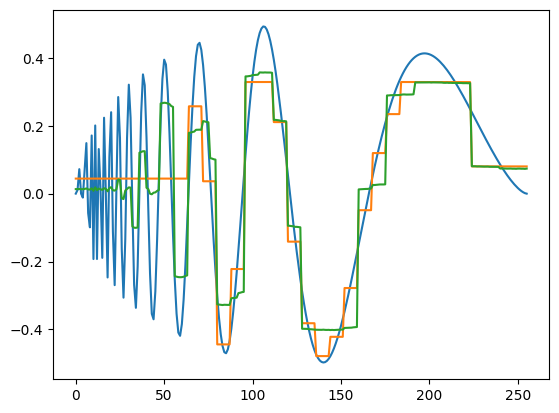

In [14]:
 
plt.plot(doppler (x))

plt.plot(tt_gnn)
plt.plot(tt_ash)

In [15]:
mse_ash = np.mean((tt_gnn- doppler (x))**2)
mse_gnn_ash = np.mean((tt_ash - doppler (x))**2)
print(f"MSE (Ash Post vs True): {mse_ash:.4f}")
print(f"MSE (Gnn ash Est  vs   True): {mse_gnn_ash:.4f}")

MSE (Ash Post vs True): 0.0205
MSE (Gnn ash Est  vs   True): 0.0154
